# Importing Package and Utitlis

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, GlobalAveragePooling2D, Input, Flatten, MaxPooling2D
from tensorflow.keras import Model, Sequential, applications
from PIL import Image
from matplotlib import image
import cv2 as cv
np.random.seed(2022)

# Loading the images

In [2]:
# loading image
IMG_SHAPE = 300
batch_size = 32
data_dir = '../input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
all_ds = tf.keras.preprocessing.image_dataset_from_directory(
                            data_dir,
                            image_size=(IMG_SHAPE, IMG_SHAPE),
                            seed= 2022,
                            batch_size=4200,
                            )
# loading the training image
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                            data_dir,
                            image_size = (IMG_SHAPE, IMG_SHAPE),
                            batch_size=batch_size,
                            subset= 'training',
                            shuffle=True,
                            seed=2022,
                            validation_split = 0.2
                            )
# loading the testing image
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
                            data_dir,
                            seed=2022,
                            image_size=(IMG_SHAPE, IMG_SHAPE),
                            subset='validation',
                            shuffle=True,
                            validation_split = 0.2,
                            batch_size=batch_size)

Found 4200 files belonging to 2 classes.


2022-08-09 13:07:41.632094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 13:07:41.731395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 13:07:41.732219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-09 13:07:41.737639: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 4200 files belonging to 2 classes.
Using 3360 files for training.
Found 4200 files belonging to 2 classes.
Using 840 files for validation.


In [3]:
#accessing the shape of the images 
inf_img = cv.imread('../input/tb-testing-data/18373.jpg')
inf_img = cv.resize(inf_img, (IMG_SHAPE, IMG_SHAPE))
inf_img = inf_img /255.
inf_img = np.expand_dims(inf_img, 0)
inf_img.shape

(1, 300, 300, 3)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, zoom_range= .3, rotation_range =50, height_shift_range=.2, width_shift_range=.2, shear_range=.2,
                                                               horizontal_flip=True, vertical_flip=True, validation_split=.2)
train_ds = train_datagen.flow_from_directory(data_dir,
                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            subset='training'
                                            )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225, validation_split=.2)
test_ds = test_datagen.flow_from_directory(data_dir,
                      batch_size=batch_size,
                      target_size=(IMG_SHAPE, IMG_SHAPE),
                      class_mode='binary',
                      subset='validation'
                      )


# Converting labels to their average weighted value to cover for Data Imbalance 

In [4]:
#getting the labels of all the datasets.
lables = np.concatenate([i for x, i in all_ds], axis=0)

2022-08-09 13:07:45.335733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-09 13:07:55.342441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1139 of 33600
2022-08-09 13:08:05.355338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 2239 of 33600
2022-08-09 13:08:15.344540: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 3402 of 33600
2022-08-09 13:08:22.213592: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-08-09 13:08:22.238946: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 4536000000 exceeds 10% of free system memory.


In [5]:
len(lables[lables==0])

3500

In [6]:
#getting the +ve and negative bicount
neg, pos = np.bincount(lables)
total = neg + pos

In [7]:
weight_of_0 = (1/neg) * (total/2.0)
weight_of_1 = (1/pos) * (total/2.0)
class_weights = {0:weight_of_0, 1:weight_of_1}

In [8]:
weight_of_0

0.6000000000000001

In [9]:
#deleting this because it takes up too much ram space 
del lables

In [10]:
classes = train_ds.class_names
classes

['Normal', 'Tuberculosis']

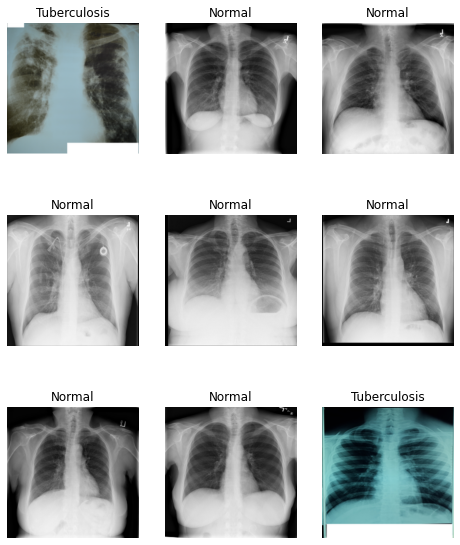

In [11]:
#sampling the data with respect to their labels
plt.figure(figsize=(8,10))
for img, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(classes[label[i]])
        plt.axis('off')
        

In [12]:
# preprocessing
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
dir(applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [14]:
#creating the model
def base_model(shape, finetune=False):
    #defining input layer
    input_layer = Input(shape=shape)
    # defining scaling layer
    preprocess_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input_layer)
    #loading pretrained model
    print(preprocess_layer.shape)
    pretrained_model = applications.InceptionV3(input_shape= preprocess_layer.shape[1:], include_top =False, weights= 'imagenet')
    
    #freezing all the layers if finetune is false
    if finetune == False:
        pretrained_model.trainable = False
    #unfreezing 10 percent
    else:
        pretrained_model.trainble = True
        #getting the finetune number
        finetune_at = len(pretrained_model.layers) - int(len(pretrained_model.layers) * .05)
        
        #freezing point
        for layer in pretrained_model.layers[:finetune_at]:
            layer.trainable = False
        
        # checking to see if they were truely frozen
        for i, layer in enumerate(pretrained_model.layers):
            print(i, layer.name, layer.trainable)
        
    base_input = pretrained_model(preprocess_layer)
    p1 = GlobalAveragePooling2D()(base_input)
    
    #flatten
    flat = Flatten()(p1)
    
    output = Dense(1, activation='sigmoid')(flat)
    
    model = Model(outputs=output, inputs=input_layer)
    
    return model
    

In [15]:
model = base_model(shape = (IMG_SHAPE, IMG_SHAPE, 3), finetune = True)
model.summary()

(None, 300, 300, 3)
87924736/87910968 [==============================] - 4s 0us/step
0 input_2 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 a

In [16]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer= tf.keras.optimizers.RMSprop(learning_rate= 0.00001),
              metrics= [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [17]:
history = model.fit(train_ds, validation_data=test_ds, epochs=20, batch_size=32, class_weight=class_weights)


Epoch 1/20


2022-08-09 13:08:43.782154: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


105/105 [==============================] - 45s 306ms/step - loss: 0.5852 - binary_accuracy: 0.7872 - precision: 0.4280 - recall: 0.7365 - val_loss: 0.4268 - val_binary_accuracy: 0.9286 - val_precision: 0.8526 - val_recall: 0.6378
Epoch 2/20
105/105 [==============================] - 32s 294ms/step - loss: 0.4387 - binary_accuracy: 0.9057 - precision: 0.6592 - recall: 0.9250 - val_loss: 0.3320 - val_binary_accuracy: 0.9619 - val_precision: 0.8992 - val_recall: 0.8425
Epoch 3/20
105/105 [==============================] - 32s 289ms/step - loss: 0.3538 - binary_accuracy: 0.9399 - precision: 0.7616 - recall: 0.9424 - val_loss: 0.2777 - val_binary_accuracy: 0.9643 - val_precision: 0.8943 - val_recall: 0.8661
Epoch 4/20
105/105 [==============================] - 33s 302ms/step - loss: 0.3013 - binary_accuracy: 0.9512 - precision: 0.8057 - recall: 0.9407 - val_loss: 0.2448 - val_binary_accuracy: 0.9667 - val_precision: 0.8837 - val_recall: 0.8976
Epoch 5/20
105/105 [===========================

## creating csv tracking template

# Storing the Results and Model Evalution

In [18]:
data = pd.DataFrame({'loss':[], 'binary_accuracy': [], 'precision':[], 'recall':[], 'model':[]})


In [19]:
model_name = 'InceptionV3'
evall = model.evaluate(test_ds)


27/27 [==============================] - 7s 186ms/step - loss: 0.0923 - binary_accuracy: 0.9857 - precision: 0.9259 - recall: 0.9843


In [20]:
evall

[0.0923374593257904,
 0.9857142567634583,
 0.9259259104728699,
 0.9842519760131836]

In [21]:
evall.append(model_name)
data.loc[len(data.index)] = evall

In [22]:
data.head()

,loss,binary_accuracy,precision,recall,model
0,0.092337,0.985714,0.925926,0.984252,InceptionV3


In [23]:
data.to_csv('experiments.csv', index =False)

data = pd.read_csv('experiments.csv')

#evaluating model
model_name = 'ResNet101'
evall = model.evaluate(test_ds)

#adding result to csv
evall.append(model_name)
data.loc[len(data.index)] = evall

#writing csv
data.to_csv('experiments.csv', index =False)

In [24]:
history.history.keys()

dict_keys(['loss', 'binary_accuracy', 'precision', 'recall', 'val_loss', 'val_binary_accuracy', 'val_precision', 'val_recall'])

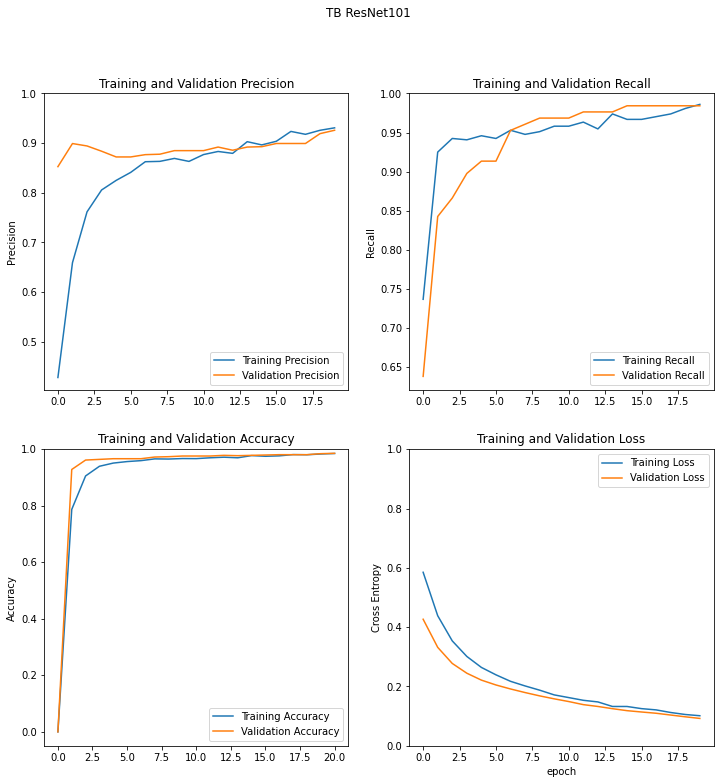

In [25]:
acc = [0.] + history.history['binary_accuracy']
val_acc = [0.] + history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

fig = plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Precision')


plt.subplot(2, 2, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='lower right')
plt.ylabel('Recall')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Recall')


plt.subplot(2, 2, 3)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')


plt.subplot(2, 2, 4)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
fig.suptitle('TB ResNet101')
plt.savefig('ResNet101.png')  
plt.show()

In [26]:
model.predict(inf_img)

array([[0.98938215]], dtype=float32)

In [27]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


In [28]:
model.save('saved_model/inceptionv3')

2022-08-09 13:23:09.446631: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [29]:
os.listdir('saved_model/inceptionv3')

['keras_metadata.pb', 'variables', 'assets', 'saved_model.pb']

In [30]:
import shutil
shutil.make_archive('tb_model', 'zip', './saved_model/inceptionv3')

'/kaggle/working/tb_model.zip'